## Example: Joint inference of $p(G, \Theta | \mathcal{D})$ for Gaussian Bayes nets

DiBS translates the task of inferring the posterior over Bayesian networks into an inference problem over the continuous latent variable $Z$. This is achieved by modeling the directed acyclic graph $G$ of the Bayesian network using the generative model $p(G | Z)$. The prior $p(Z)$ enforces the acyclicity of $G$.
Ultimately, this allows us to infer $p(Z, \Theta | \mathcal{D})$ (or $p(Z | \mathcal{D})$) instead of $p(G, \Theta | \mathcal{D})$ (or $p(G | \mathcal{D})$, respectively) using off-the-shelf inference methods, such as Stein Variational gradient descent (SVGD) (Liu and Wang, 2016).

In [1]:
from IPython import display
import jax.numpy as jnp
from jax import jit, vmap
from jax import random

from dibs.inference import JointDiBS
from dibs.kernel import JointAdditiveFrobeniusSEKernel

from dibs.eval.target import make_linear_gaussian_model, make_nonlinear_gaussian_model
from dibs.eval.metrics import expected_shd, threshold_metrics, neg_ave_log_likelihood
            
from dibs.utils.graph import elwise_acyclic_constr_nograd as constraint
from dibs.utils.func import joint_dist_to_marginal, particle_joint_empirical, particle_joint_mixture
from dibs.utils.visualize import visualize, visualize_ground_truth

from dibs.config.example import DiBSExampleSettings

key = random.PRNGKey(123)

### Generate synthetic ground truth Bayesian network and corresponding target densities for inference

Below, the default synthetic Bayesian network (BN) sampled is a linear Gaussian network (for computational efficiency in this notebook). The random graph model is chosen via `graph_prior_str`, where `er` denotes Erdos-Renyi and `sf` scale-free graphs.

The only change required to **infer nonlinear Gaussian networks parameterized by fully-connected neural networks is commenting in the line with `make_nonlinear_gaussian_model`.**

In [2]:
"""Sample synthetic Bayesian network"""
n_vars = 20
key, subk = random.split(key)
target = make_linear_gaussian_model(key=subk, n_vars=n_vars, graph_prior_str="sf")
# target = make_nonlinear_gaussian_model(key=subk, n_vars=n_vars, graph_prior_str="sf")

# train and held-out observations
x = jnp.array(target.x)
x_ho = jnp.array(target.x_ho)

In [3]:
"""Generate target densities for posterior inference"""
model = target.inference_model
print(type(model).__name__)

no_interv_targets = jnp.zeros(n_vars).astype(bool) # observational data

def log_prior(single_w_prob):
    """log p(G) using edge probabilities as G"""
    return target.graph_model.unnormalized_log_prob_soft(soft_g=single_w_prob)

def log_joint_target(single_w, single_theta, rng):
    """log p(theta, D | G) =  log p(theta | G) + log p(D | G, theta)"""
    log_prob_theta = model.log_prob_parameters(theta=single_theta, w=single_w)
    log_lik = model.log_likelihood(theta=single_theta, w=single_w, data=x, interv_targets=no_interv_targets)
    return log_prob_theta + log_lik

eltwise_log_prob = vmap(lambda g, theta: log_joint_target(g, theta, None), (0, 0), 0)

LinearGaussianJAX


### Prepare DiBS

Randomly initialize particles and prepare visualization.

To explicitly only perform marginal posterior inference of $p(G | \mathcal{D})$ and marginalize out the parameters in closed-form, e.g., using the BGe score, all appearances of the parameters $\Theta$ need to be dropped. Since several function signatures change under the hood, there is a separate analogous class `dibs.svgd.marginal_dibs_svgd.MarginalDiBS`.


In [4]:
# SVGD + DiBS hyperparams
n_particles = 20
n_steps = 1000
hparams = DiBSExampleSettings()

# initialize kernel and algorithm
kernel = JointAdditiveFrobeniusSEKernel(
    h_latent=hparams.h_latent,
    h_theta=hparams.h_theta)

dibs = JointDiBS(
    kernel=kernel, 
    target_log_prior=log_prior,
    target_log_joint_prob=log_joint_target,
    alpha_linear=hparams.alpha_linear)
        
# initialize particles
key, subk = random.split(key)
init_z, init_theta = dibs.sample_initial_random_particles(
    key=subk, model=model, n_particles=n_particles, n_vars=n_vars)

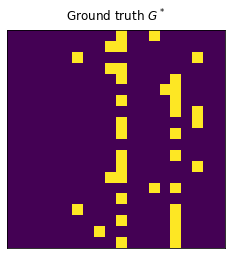

In [5]:
# prepare visualization
images = []
def callback(**kwargs):
    zs = kwargs["zs"]
    gs = kwargs["dibs"].particle_to_g_lim(zs)
    probs = kwargs["dibs"].edge_probs(zs, kwargs["t"])
    display.clear_output(wait=True)
    visualize(probs,  save_path=hparams.save_path, t=kwargs["t"], show=True)
    print(
        f'iteration {kwargs["t"]:6d}'
        f' | alpha {dibs.alpha(kwargs["t"]):6.1f}'
        f' | beta {dibs.beta(kwargs["t"]):6.1f}'
        f' | #cyclic {(constraint(kwargs["dibs"].particle_to_g_lim(zs), n_vars) > 0).sum().item():3d}'
    )
    return

# visualize ground truth (to be inferred)
visualize_ground_truth(target.g)

### Run DiBS with SVGD

Visualization shows the *matrix of edge probabilities* $G_\alpha(Z^{(k)})$ implied by each transported latent particle (i.e., sample) $Z^{(k)}$. Refer to the paper for further details. Probabilities around 0.0 are shown in blue, around 1.0 in yellow.

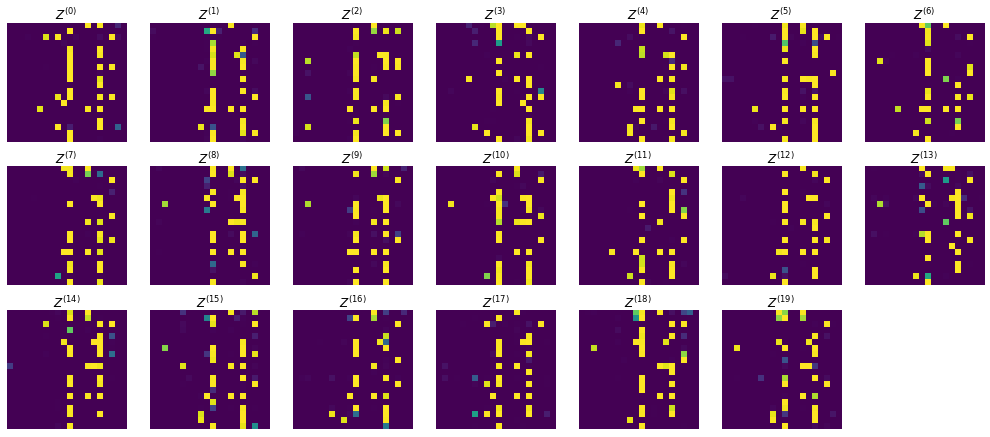

iteration   1000 | alpha  100.0 | beta 1000.0 | #cyclic   0
CPU times: user 4min 48s, sys: 4.96 s, total: 4min 53s
Wall time: 2min


In [6]:
%%time
# iteratively transport particles 
key, subk = random.split(key)
z, theta = dibs.sample_particles(key=subk, n_steps=n_steps, 
    init_z=init_z, init_theta=init_theta, callback_every=50, callback=callback)

### Evaluate on held-out data

As $\alpha \rightarrow \infty$, we may convert $G_\alpha(Z)$ to $G_\infty(Z)$ and obtain a discrete graph adjacency marix.

In [7]:
g = dibs.particle_to_g_lim(z)

Form the empirical (i.e., uniformly weighted) and mixture distributions (denoted DiBS+ in the paper) based on the unnormalized posterior probabilities.

In [8]:
dibs_empirical = particle_joint_empirical(g, theta)
dibs_mixture = particle_joint_mixture(g, theta, eltwise_log_prob)

Compute some evaluation metrics.

In [9]:
# evaluates log likelihood of all (G, theta) particles in batch on held-out data
eltwise_log_likelihood = jit(vmap(lambda w_, theta_, x_: \
    (model.log_likelihood(theta=theta_, w=w_, data=x_, interv_targets=no_interv_targets)), (0, 0, None), 0))

In [10]:
# print metrics
for descr, dist in [('DiBS ', dibs_empirical), ('DiBS+', dibs_mixture)]:
    dist_marginal = joint_dist_to_marginal(dist)
    
    eshd = expected_shd(dist=dist_marginal, g=target.g)        
    auroc = threshold_metrics(dist=dist_marginal, g=target.g)['roc_auc']
    negll = neg_ave_log_likelihood(dist=dist, eltwise_log_joint_target=eltwise_log_likelihood, x=x_ho)
    
    print(f'{descr} |  E-SHD: {eshd:4.1f}    AUROC: {auroc:5.2f}    neg. LL {negll:5.2f}')
               

DiBS  |  E-SHD: 23.0    AUROC:  0.95    neg. LL 851.38
DiBS+ |  E-SHD: 19.0    AUROC:  0.93    neg. LL 742.15
